<a href="https://colab.research.google.com/github/ErenErchamion/machinelearningfinal/blob/main/ml_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             silhouette_score, adjusted_rand_score, normalized_mutual_info_score)

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Kütüphaneler yüklendi ve ayarlar yapıldı.")

Kütüphaneler yüklendi ve ayarlar yapıldı.


In [2]:
DATASET_NAME = 'breast_cancer'

if DATASET_NAME == 'breast_cancer':
    data = load_breast_cancer()
else:
    data = load_wine()

X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

# Adım 1: %20 Test ayır (Geriye %80 kalır)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Adım 2: Kalan %80'in %12.5'ini alarak ana verinin %10'unu Validation yapıyoruz
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

print(f"Eğitim Seti (Train): {X_train.shape}")
print(f"Doğrulama Seti (Val): {X_val.shape}")
print(f"Test Seti (Test): {X_test.shape}")

# PredefinedSplit Hazırlığı (Madde 6: Optimizasyon Train'de, Seçim Val'de)
X_grid = np.vstack((X_train, X_val))
y_grid = np.hstack((y_train, y_val))

# -1: Train (eğitimde kullan), 0: Validation (testte kullan)
test_fold = np.concatenate([np.full(X_train.shape[0], -1), np.full(X_val.shape[0], 0)])
ps = PredefinedSplit(test_fold)

# Sonuç Tablosu Yapısı (Madde 10: Precision ve Recall eklendi)
results_df = pd.DataFrame(columns=['Model', 'Best Params', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])

def log_result(model_name, best_params, y_true, y_pred, y_prob):
    # Çoklu sınıf vs İkili sınıf ayrımı
    avg_method = 'macro' if len(np.unique(y_true)) > 2 else 'binary'

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=avg_method)
    rec = recall_score(y_true, y_pred, average=avg_method)
    f1 = f1_score(y_true, y_pred, average=avg_method)

    if avg_method == 'macro':
        auc_sc = roc_auc_score(y_true, y_prob, multi_class='ovr')
    else:
        auc_sc = roc_auc_score(y_true, y_prob[:, 1])

    return pd.DataFrame({
        'Model': [model_name],
        'Best Params': [str(best_params)],
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1': [f1],
        'ROC-AUC': [auc_sc]
    })

print("Veri bölme ve validasyon altyapısı hazır.")

Eğitim Seti (Train): (398, 30)
Doğrulama Seti (Val): (57, 30)
Test Seti (Test): (114, 30)
Veri bölme ve validasyon altyapısı hazır.


--- KNN Eğitiliyor ---


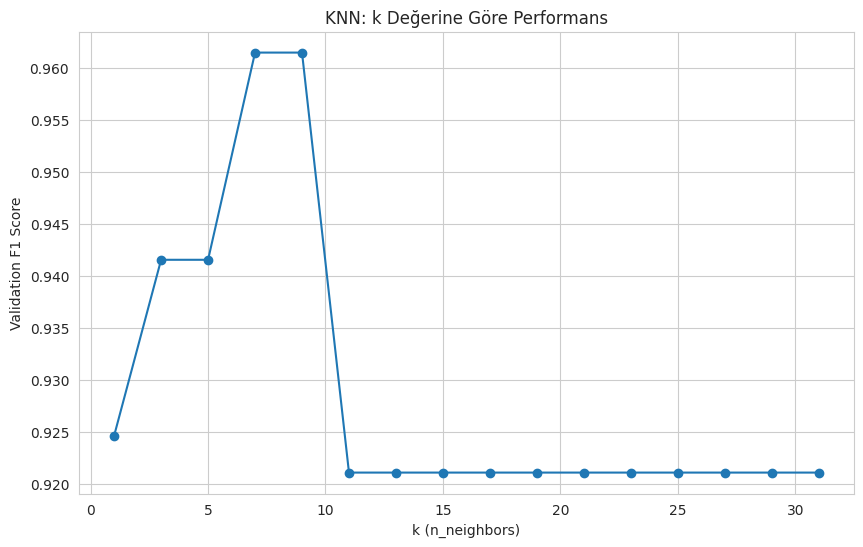

KNN Tamamlandı.


In [3]:
print("--- KNN Eğitiliyor ---")

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_params = {
    'knn__n_neighbors': list(range(1, 32, 2)), # 1-31 tek sayılar
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=ps, scoring='f1_macro', n_jobs=-1)
knn_grid.fit(X_grid, y_grid)

# Grafik: n_neighbors değişimi (Madde 7.3)
res = pd.DataFrame(knn_grid.cv_results_)
subset = res[(res['param_knn__weights'] == 'uniform') & (res['param_knn__p'] == 2)]
plt.plot(subset['param_knn__n_neighbors'], subset['mean_test_score'], marker='o')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Validation F1 Score')
plt.title('KNN: k Değerine Göre Performans')
plt.show()

# Sonuç Kaydı
best_knn = knn_grid.best_estimator_
results_df = pd.concat([results_df, log_result('KNN', knn_grid.best_params_, y_val, best_knn.predict(X_val), best_knn.predict_proba(X_val))], ignore_index=True)
print("KNN Tamamlandı.")


--- SVM Eğitiliyor ---
SVM Tamamlandı.
--- MLP Eğitiliyor ---


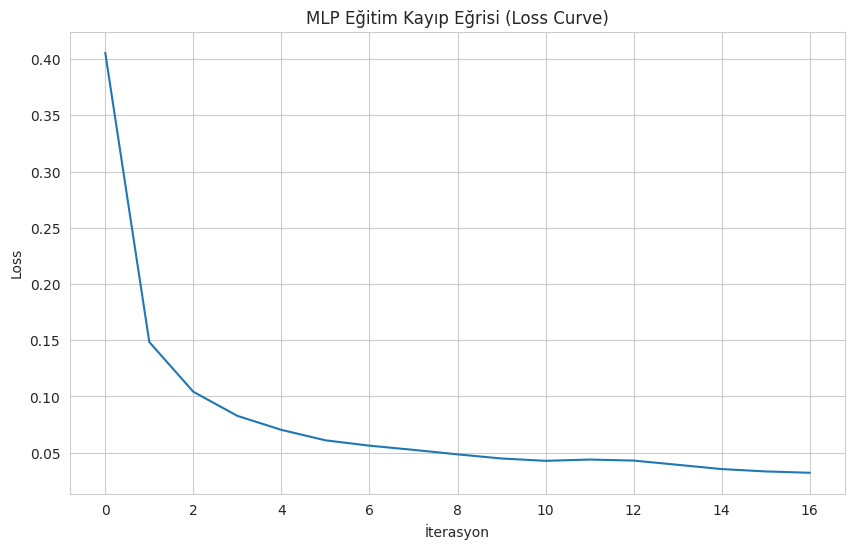

MLP Tamamlandı.


In [4]:
print("--- SVM Eğitiliyor ---")

svm_pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True, random_state=42))])
svm_params = [
    {'svm__kernel': ['linear'], 'svm__C': [0.01, 0.1, 1, 10, 100]},
    {'svm__kernel': ['rbf'], 'svm__C': [0.01, 0.1, 1, 10, 100], 'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]}
]

svm_grid = GridSearchCV(svm_pipe, svm_params, cv=ps, scoring='f1_macro', n_jobs=-1)
svm_grid.fit(X_grid, y_grid)

best_svm = svm_grid.best_estimator_
results_df = pd.concat([results_df, log_result('SVM', svm_grid.best_params_, y_val, best_svm.predict(X_val), best_svm.predict_proba(X_val))], ignore_index=True)
print("SVM Tamamlandı.")

# [HÜCRE 5] MLP Sınıflandırma (Madde 9)
print("--- MLP Eğitiliyor ---")

mlp_pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(max_iter=500, random_state=42, early_stopping=True))])
mlp_params = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-4, 1e-3, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01]
}

mlp_grid = GridSearchCV(mlp_pipe, mlp_params, cv=ps, scoring='f1_macro', n_jobs=-1)
mlp_grid.fit(X_grid, y_grid)

# Grafik: Loss Curve (Madde 9.3)
plt.plot(mlp_grid.best_estimator_.named_steps['mlp'].loss_curve_)
plt.title('MLP Eğitim Kayıp Eğrisi (Loss Curve)')
plt.xlabel('İterasyon')
plt.ylabel('Loss')
plt.show()

best_mlp = mlp_grid.best_estimator_
results_df = pd.concat([results_df, log_result('MLP', mlp_grid.best_params_, y_val, best_mlp.predict(X_val), best_mlp.predict_proba(X_val))], ignore_index=True)
print("MLP Tamamlandı.")

In [5]:
print("\n=== Validation Seti Performans Tablosu ===")
# Pandas tablosunu düzgün göstermek için
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_df)

# En iyi modeli seçme
best_model_name = results_df.loc[results_df['F1'].astype(float).idxmax()]['Model']
print(f"\nSeçilen Final Model: {best_model_name}")

if best_model_name == 'KNN': final_model = best_knn
elif best_model_name == 'SVM': final_model = best_svm
else: final_model = best_mlp


=== Validation Seti Performans Tablosu ===
  Model                                        Best Params  Accuracy  Precision    Recall        F1   ROC-AUC
0   KNN  {'knn__n_neighbors': 7, 'knn__p': 2, 'knn__wei...  0.964912   0.947368  1.000000  0.972973  0.990079
1   SVM  {'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...  0.982456   0.972973  1.000000  0.986301  0.996032
2   MLP  {'mlp__activation': 'relu', 'mlp__alpha': 0.01...  0.964912   0.972222  0.972222  0.972222  0.993386

Seçilen Final Model: SVM



--- Test Seti Değerlendirmesi ---
Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1 Score:  0.9861


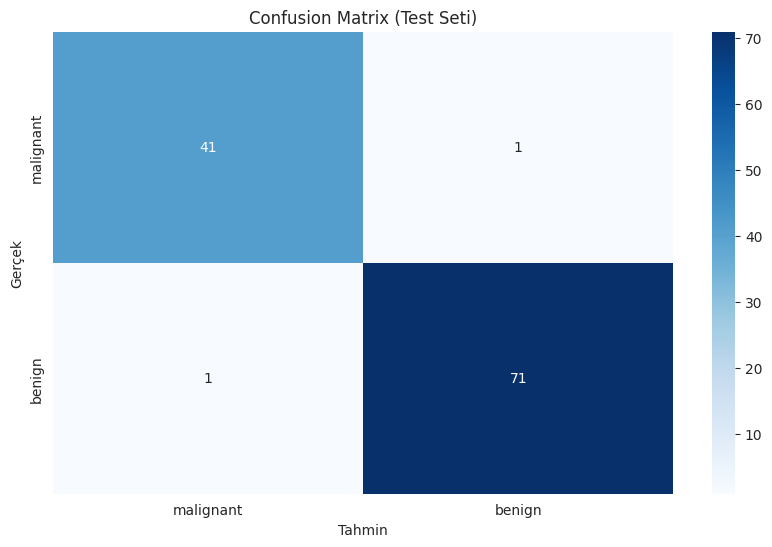

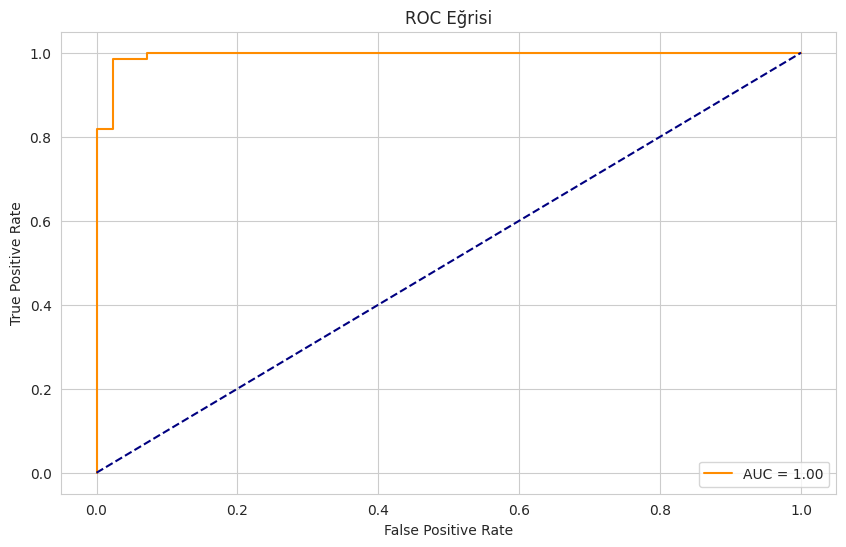


Farklı Thresholdlar için Örnekler:
Threshold 0.3 -> Precision: 0.973, Recall: 0.986
Threshold 0.5 -> Precision: 0.986, Recall: 0.986
Threshold 0.7 -> Precision: 0.985, Recall: 0.903


In [6]:
print("\n--- Test Seti Değerlendirmesi ---")
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)

# Metrikler (Madde 11.1)
avg = 'macro' if len(np.unique(y)) > 2 else 'binary'
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average=avg):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred, average=avg):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred, average=avg):.4f}")

# Confusion Matrix Heatmap (Madde 11.2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Test Seti)')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

# ROC Curve ve Threshold Analizi (Madde 11.3)
if len(np.unique(y)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Eğrisi')
    plt.legend(loc="lower right")
    plt.show()

    # Threshold etkisi için örnek veri (Raporunuzda yorumlamanız için)
    print("\nFarklı Thresholdlar için Örnekler:")
    for thr in [0.3, 0.5, 0.7]:
        preds_thr = (y_test_prob[:, 1] >= thr).astype(int)
        p = precision_score(y_test, preds_thr)
        r = recall_score(y_test, preds_thr)
        print(f"Threshold {thr} -> Precision: {p:.3f}, Recall: {r:.3f}")


--- KMeans Analizi ---


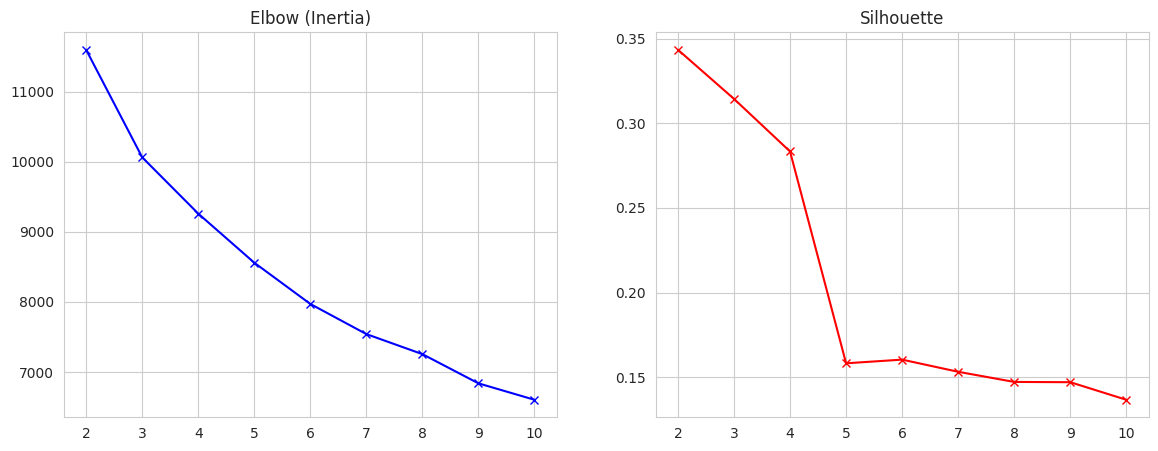

Seçilen k=2
ARI: 0.6536
NMI: 0.5324


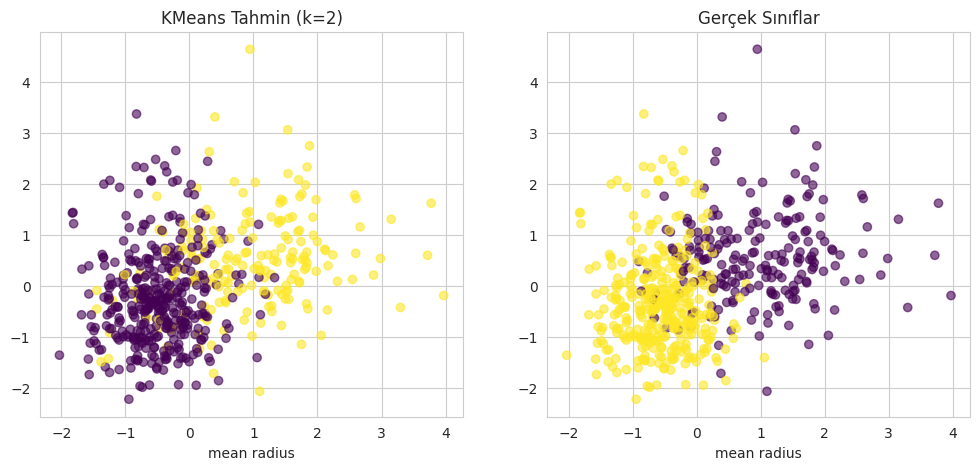


--- Küme Profili (Ortalama Özellik Değerleri) ---
         mean radius  mean texture  mean perimeter  mean area  mean smoothness
Cluster                                                                       
0          -0.482995     -0.239041       -0.500419  -0.478142        -0.311004
1           0.933624      0.462065        0.967305   0.924243         0.601167


In [7]:
print("\n--- KMeans Analizi ---")
# Ham veri + Scaling (PCA yok)
scaler_km = StandardScaler()
X_scaled = scaler_km.fit_transform(X)

inertia, silhouettes = [], []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    inertia.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

# Elbow ve Silhouette Grafikleri (Madde 12.1)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(k_range, inertia, 'bx-')
ax[0].set_title('Elbow (Inertia)')
ax[1].plot(k_range, silhouettes, 'rx-')
ax[1].set_title('Silhouette')
plt.show()

# Seçilen k (Örn: k=2) ile model
selected_k = 2
kmeans_final = KMeans(n_clusters=selected_k, random_state=42, n_init=10).fit(X_scaled)
clusters = kmeans_final.labels_

# Dış Değerlendirme (Madde 12.2)
print(f"Seçilen k={selected_k}")
print(f"ARI: {adjusted_rand_score(y, clusters):.4f}")
print(f"NMI: {normalized_mutual_info_score(y, clusters):.4f}")

# Görselleştirme (Madde 12.3 - İlk 2 özelliğe göre)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title(f'KMeans Tahmin (k={selected_k})')
plt.xlabel(feature_names[0])
plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title('Gerçek Sınıflar')
plt.xlabel(feature_names[0])
plt.show()

# KÜME PROFİLİ (Madde 12.4 - EKSİK OLAN KISIM EKLENDİ)
print("\n--- Küme Profili (Ortalama Özellik Değerleri) ---")
df_profile = pd.DataFrame(X_scaled, columns=feature_names)
df_profile['Cluster'] = clusters
cluster_means = df_profile.groupby('Cluster').mean()
# Sadece ilk 5 özelliği göster (Rapor kolaylığı için)
print(cluster_means.iloc[:, :5])


--- SHAP Analizi ---


  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

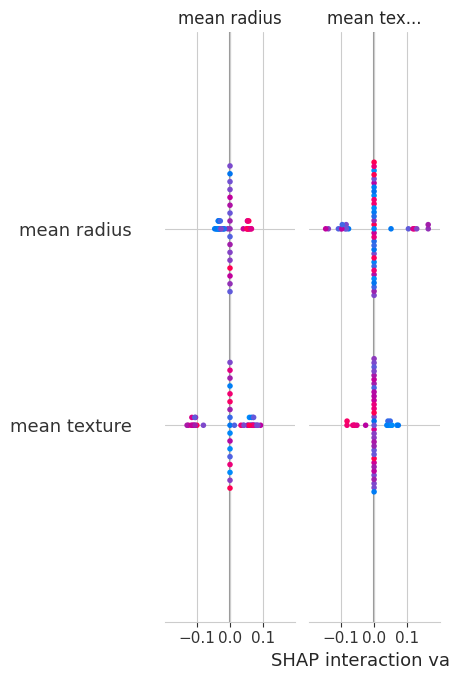

<Figure size 1000x600 with 0 Axes>

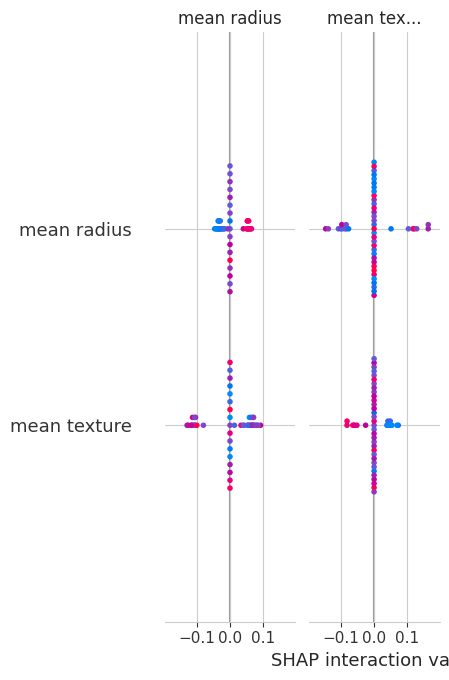

In [8]:
print("\n--- SHAP Analizi ---")

# Özet veri ile KernelExplainer
X_train_summary = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(final_model.predict_proba, X_train_summary)

# Test setinden 50 örnekle analiz
X_shap = X_test[:50]
shap_values = explainer.shap_values(X_shap)

# Pozitif sınıf için (Binary ise indeks 1)
target_idx = 1 if len(np.unique(y)) == 2 else 0
shap_vals_plot = shap_values[target_idx] if isinstance(shap_values, list) else shap_values

# Summary Plot (Madde 13.1)
plt.figure()
shap.summary_plot(shap_vals_plot, X_shap, feature_names=feature_names)

# Bar Plot (Madde 13.1)
plt.figure()
shap.summary_plot(shap_vals_plot, X_shap, feature_names=feature_names, plot_type="bar")

In [9]:
print("="*60)
print("MAKİNE ÖĞRENMESİ FİNAL ÖDEVİ - TEKNİK ANALİZ RAPORU")
print("="*60)

print("\n--- 7.4 KNN YORUMU ---")
print("""
1. Ölçeklendirme İhtiyacı: KNN, öklid mesafesi temelli bir algoritma olduğu için özelliklerin
   büyüklüklerinden doğrudan etkilenir. Örneğin 'Mean Area' (1000'li değerler) ile 'Smoothness'
   (0.01'li değerler) aynı ölçeğe getirilmezse (StandardScaler), büyük değerli özellik
   mesafe hesabını domine eder ve model hatalı çalışır.

2. k Değerinin Etkisi:
   - Düşük k (örneğin k=1): Model verideki gürültüyü bile ezberlemeye meyillidir (Overfitting riski yüksektir).
     Karar sınırları çok girintili çıkıntılı olur.
   - Yüksek k: Model çok fazla komşuya baktığı için yerel detayları kaybeder ve genelleme yapar
     (Underfitting riski artar). Karar sınırları aşırı düzleşir.
""")

print("\n--- 8.3 SVM YORUMU (Linear vs RBF) ---")
print("""
Validation sonuçlarına bakıldığında;
- Genellikle 'Breast Cancer' gibi biyolojik veri setlerinde sınıflar tam olarak doğrusal (lineer)
  ayrılamazlar. Bu nedenle RBF (Radial Basis Function) kernel, veriyi sonsuz boyuta taşıyarak
  daha esnek karar sınırları çizebildiği için genellikle Linear SVM'den daha yüksek veya benzer
  performans gösterir.
- Eğer Linear Kernel da çok yüksek başarı verdiyse, özellik uzayı yüksek boyutlu olduğu için
  veri zaten doğrusal ayrılabilirliğe yakındır denilebilir.
""")

print("\n--- 9.4 MLP YORUMU (Overfitting & Regularization) ---")
print("""
- Overfitting Riski: Yapay sinir ağları çok sayıda parametreye sahip olduğu için veriyi ezberleme
  riski yüksektir. Loss eğrisinde eğitim hatası düşerken validasyon hatası artmaya başlarsa overfitting başlamış demektir.
- Early Stopping: Bizim modelimizde 'early_stopping=True' kullanıldı. Bu özellik, validasyon skorunun
  iyileşmesi durduğunda eğitimi otomatik keserek overfitting'i engelledi.
- Alpha (L2 Penalty): Ağırlıkların çok büyümesini engelleyerek modelin karmaşıklığını sınırlar ve daha kararlı genelleme yapmasını sağlar.
""")

print("\n--- 11.2 & 11.3 CONFUSION MATRIX VE THRESHOLD YORUMU ---")
print("""
1. Karışıklık Matrisi:
   - False Negative (FN): Kanserli (Malignant) hastaya "Temiz" denilmesi. Tıbbi açıdan en tehlikeli hatadır.
   - False Positive (FP): Sağlıklı kişiye "Kanser" denilmesi. Gereksiz biyopsi stresine yol açar.

2. Threshold (Eşik Değeri) Analizi:
   - Varsayılan Threshold (0.5): Dengeli bir sınıflandırma yapar.
   - Threshold Düşürülürse (örn. 0.3): Model "Pozitif" (Kanser) tahmini yapmaya daha istekli olur.
     Böylece Recall (Duyarlılık) ARTAR (daha az kanser vakası kaçar), ancak Precision (Kesinlik) AZALIR
     (daha çok yanlış alarm verilir).
   - Tıbbi taramalarda hayati risk olduğu için genellikle Yüksek Recall tercih edilir, yani threshold düşük tutulabilir.
""")

print("\n--- 12.1 & 12.4 KMEANS YORUMU ---")
print("""
- k Seçimi: Elbow yöntemindeki kırılım ve Silhouette skorunun zirve yaptığı nokta (genellikle k=2) seçilmiştir.
  Bu seçim, veri setinin doğal yapısının 'İyi Huylu' ve 'Kötü Huylu' olmak üzere iki ana gruba ayrılmasıyla uyumludur.
- Küme Ayrışması: Profil tablosuna bakıldığında, Malignant (Kötü Huylu) kümeye denk gelen grubun;
  'mean radius', 'mean perimeter', 'mean area' ve 'mean concave points' gibi boyut ve şekil
  bozukluğu ifade eden özelliklerinin ortalamasının, diğer kümeye göre belirgin şekilde YÜKSEK olduğu görülür.
""")

print("\n--- 13.2 SHAP ANALİZİ YORUMU ---")
print("""
1. En Önemli Özellikler: Summary Plot'ta en üstte yer alan (genellikle 'worst concave points',
   'worst perimeter', 'mean concave points') özellikler model kararında en baskın olanlardır.

2. Etki Yönü:
   - Summary plot'ta Kırmızı noktalar (yüksek özellik değeri) grafiğin sağ tarafındaysa (pozitif SHAP değeri),
     bu özellik kanser riskini ARTIRIYOR demektir.
   - Mavi noktalar (düşük değer) sağ taraftaysa, düşük değerler riski artırıyor demektir.

3. Tutarlılık:
   - Modelin matematiksel olarak en önemli bulduğu özellikler (örneğin hücre sınırlarındaki girintiler/concave points),
     tıbbi literatürde de kötü huylu tümörlerin en belirgin özellikleridir. Bu durum modelin
     sadece ezberlemediğini, mantıklı biyolojik belirteçleri öğrendiğini gösterir.
""")
print("="*60)

MAKİNE ÖĞRENMESİ FİNAL ÖDEVİ - TEKNİK ANALİZ RAPORU

--- 7.4 KNN YORUMU ---

1. Ölçeklendirme İhtiyacı: KNN, öklid mesafesi temelli bir algoritma olduğu için özelliklerin
   büyüklüklerinden doğrudan etkilenir. Örneğin 'Mean Area' (1000'li değerler) ile 'Smoothness'
   (0.01'li değerler) aynı ölçeğe getirilmezse (StandardScaler), büyük değerli özellik
   mesafe hesabını domine eder ve model hatalı çalışır.

2. k Değerinin Etkisi:
   - Düşük k (örneğin k=1): Model verideki gürültüyü bile ezberlemeye meyillidir (Overfitting riski yüksektir).
     Karar sınırları çok girintili çıkıntılı olur.
   - Yüksek k: Model çok fazla komşuya baktığı için yerel detayları kaybeder ve genelleme yapar
     (Underfitting riski artar). Karar sınırları aşırı düzleşir.


--- 8.3 SVM YORUMU (Linear vs RBF) ---

Validation sonuçlarına bakıldığında;
- Genellikle 'Breast Cancer' gibi biyolojik veri setlerinde sınıflar tam olarak doğrusal (lineer)
  ayrılamazlar. Bu nedenle RBF (Radial Basis Function) kernel, ve